In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data/32번 파일용 조정된 데이터.xlsx')
del df['Unnamed: 0']

In [3]:
df.dropna(inplace=True)

In [4]:
df.head(1)

,ID,거래금액(만원)_18/1,주택금융가능여부18/1,등락율18/1,전세가율18/1,전용면적18/1,건축년도18/1,건물나이18/1,거래금액(만원)_18/2,주택금융가능여부18/2,...,전세가율22/2,전용면적22/2,건축년도.17,건물나이22/2,세대수,세대당주차수,지하주차비율,관리시설수,위도,경도
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,0,0.0,31.2,60,1983.0,35.0,129500.0,0,...,21.8,60,1983.0,39.0,940.0,0.693617,0.0,5.0,37.487868,127.068988


In [5]:
where = df.iloc[:,131:133]
print(where)
gongtong = df.iloc[:,127:131]
print(gongtong)

             위도          경도
2     37.487868  127.068988
3     37.487868  127.068988
4     37.488481  127.072502
5     37.488481  127.072502
6     37.488481  127.072502
...         ...         ...
4083  37.604124  127.082326
4084  37.594222  127.075432
4088  37.595961  127.080314
4089  37.595961  127.080314
4090  37.595961  127.080314

[3295 rows x 2 columns]
         세대수    세대당주차수    지하주차비율  관리시설수
2      940.0  0.693617  0.000000    5.0
3      940.0  0.693617  0.000000    5.0
4     1060.0  1.037736  0.000000    3.0
5     1060.0  1.037736  0.000000    3.0
6     1060.0  1.037736  0.000000    3.0
...      ...       ...       ...    ...
4083   156.0  0.461538  0.000000    4.0
4084   103.0  1.708738  1.000000    4.0
4088  1544.0  0.970855  0.683122    5.0
4089  1544.0  0.970855  0.683122    5.0
4090  1544.0  0.970855  0.683122    5.0

[3295 rows x 4 columns]


In [6]:
df.drop(['건축년도18/1','건축년도.1','건축년도.2','건축년도18/4','건축년도.4','건축년도.5','건축년도.6','건축년도.7','건축년도.8','건축년도.9','건축년도.10','건축년도.11','건축년도.12','건축년도.13','건축년도.14','건축년도.15','건축년도.16','건축년도.17'], axis=1, inplace=True)
df.columns

Index(['ID', '거래금액(만원)_18/1', '주택금융가능여부18/1', '등락율18/1', '전세가율18/1',
       '전용면적18/1', '건물나이18/1', '거래금액(만원)_18/2', '주택금융가능여부18/2', '등락율18/2',
       ...
       '등락율22/2', '전세가율22/2', '전용면적22/2', '건물나이22/2', '세대수', '세대당주차수',
       '지하주차비율', '관리시설수', '위도', '경도'],
      dtype='object', length=115)

In [7]:
dic = {}
num = 1

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num:num+6]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],gongtong], axis=1)
    num += 6

dic['data1']

,거래금액(만원)_18/1,주택금융가능여부18/1,등락율18/1,전세가율18/1,전용면적18/1,건물나이18/1,세대수,세대당주차수,지하주차비율,관리시설수
2,136666.7,0,0.000000,31.2,60,35.0,940.0,0.693617,0.000000,5.0
3,177416.7,0,0.000000,25.4,80,35.0,940.0,0.693617,0.000000,5.0
4,125900.0,0,9.134234,30.1,50,35.0,1060.0,1.037736,0.000000,3.0
5,135200.0,0,9.023669,31.8,60,35.0,1060.0,1.037736,0.000000,3.0
6,151500.0,0,10.451045,33.2,70,35.0,1060.0,1.037736,0.000000,3.0
...,...,...,...,...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,27.0,156.0,0.461538,0.000000,4.0
4084,44000.0,1,0.000000,85.2,80,8.0,103.0,1.708738,1.000000,4.0
4088,31756.2,1,0.000000,77.4,50,21.0,1544.0,0.970855,0.683122,5.0
4089,36534.6,1,2.996064,76.9,60,20.9,1544.0,0.970855,0.683122,5.0


In [8]:
dic['data18']

,거래금액(만원)_22/2,주택금융가능여부22/2,등락율22/2,전세가율22/2,전용면적22/2,건물나이22/2,세대수,세대당주차수,지하주차비율,관리시설수
2,202800.0,0,0.0,21.8,60,39.0,940.0,0.693617,0.000000,5.0
3,282250.0,0,0.0,22.1,80,39.0,940.0,0.693617,0.000000,5.0
4,189000.0,0,0.0,22.8,50,39.0,1060.0,1.037736,0.000000,3.0
5,181000.0,0,0.0,21.7,60,39.0,1060.0,1.037736,0.000000,3.0
6,270000.0,0,0.0,21.2,70,39.0,1060.0,1.037736,0.000000,3.0
...,...,...,...,...,...,...,...,...,...,...
4083,56933.3,1,0.0,83.4,80,31.0,156.0,0.461538,0.000000,4.0
4084,78800.0,0,0.0,44.4,80,12.0,103.0,1.708738,1.000000,4.0
4088,70000.0,0,0.0,52.9,50,25.0,1544.0,0.970855,0.683122,5.0
4089,73000.0,0,0.0,49.5,60,24.9,1544.0,0.970855,0.683122,5.0


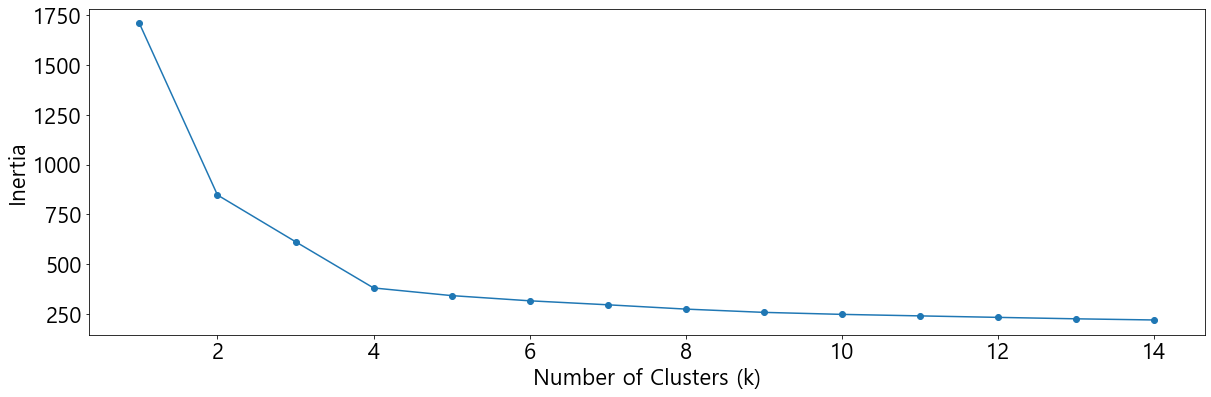

In [9]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

num_clusters = list(range(1, 15))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [12]:
# 스케일링과 클러스터링
mm = MinMaxScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [13]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,주택금융가능여부18/1,등락율18/1,전세가율18/1,전용면적18/1,건물나이18/1,세대수,세대당주차수,지하주차비율,관리시설수
cluster,,,,,,,,,,
0,614,614,614,614,614,614,614,614,614,614
1,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284
2,975,975,975,975,975,975,975,975,975,975
3,422,422,422,422,422,422,422,422,422,422


In [14]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,주택금융가능여부20/1,등락율20/1,전세가율20/1,전용면적20/1,건물나이20/1,세대수,세대당주차수,지하주차비율,관리시설수
cluster,,,,,,,,,,
0,435,435,435,435,435,435,435,435,435,435
1,677,677,677,677,677,677,677,677,677,677
2,1616,1616,1616,1616,1616,1616,1616,1616,1616,1616
3,567,567,567,567,567,567,567,567,567,567


In [15]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,주택금융가능여부22/2,등락율22/2,전세가율22/2,전용면적22/2,건물나이22/2,세대수,세대당주차수,지하주차비율,관리시설수
cluster,,,,,,,,,,
0,157,157,157,157,157,157,157,157,157,157
1,184,184,184,184,184,184,184,184,184,184
2,2322,2322,2322,2322,2322,2322,2322,2322,2322,2322
3,632,632,632,632,632,632,632,632,632,632


In [16]:
data1 = dic['data1'].groupby(['cluster','주택금융가능여부18/1']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','주택금융가능여부18/2']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','주택금융가능여부18/3']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','주택금융가능여부18/4']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','주택금융가능여부19/1']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','주택금융가능여부19/2']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','주택금융가능여부19/3']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','주택금융가능여부19/4']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','주택금융가능여부20/1']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','주택금융가능여부20/2']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','주택금융가능여부20/3']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','주택금융가능여부20/4']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','주택금융가능여부21/1']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','주택금융가능여부21/2']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','주택금융가능여부21/3']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','주택금융가능여부21/4']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','주택금융가능여부22/1']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','주택금융가능여부22/2']).count().iloc[:,1:2]

In [17]:
data1

,,등락율18/1
cluster,주택금융가능여부18/1,
0,1,614
1,1,1284
2,0,975
3,0,422


In [18]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

,,등락율18/1,등락율18/2,등락율18/3,등락율18/4,등락율19/1,등락율19/2,등락율19/3,등락율19/4,등락율20/1,등락율20/2,등락율20/3,등락율20/4,등락율21/1,등락율21/2,등락율21/3,등락율21/4,등락율22/1,등락율22/2
cluster,,,,,,,,,,,,,,,,,,,
0,1,614,597,559,544,548,543,521,484,435,399,343,304,265,206,159,155,159,157
1,1,1284,1195,1023,960,966,962,881,779,677,577,458,356,295,261,200,182,183,184
2,0,975,1053,1224,1283,1270,1293,1370,1485,1616,1741,1883,2028,2118,2209,2309,2329,2329,2322
3,0,422,450,489,508,511,497,523,547,567,578,611,607,617,619,627,629,624,632


In [19]:
ID = df.iloc[:,0]
ID

2       서울특별시 강남구 개포동 개포주공5단지 60
3       서울특별시 강남구 개포동 개포주공5단지 80
4       서울특별시 강남구 개포동 개포주공6단지 50
5       서울특별시 강남구 개포동 개포주공6단지 60
6       서울특별시 강남구 개포동 개포주공6단지 70
                  ...           
4083         서울특별시 중랑구 중화동 극동 80
4084      서울특별시 중랑구 중화동 동양엔파트 80
4088      서울특별시 중랑구 중화동 한신아파트 50
4089      서울특별시 중랑구 중화동 한신아파트 60
4090      서울특별시 중랑구 중화동 한신아파트 80
Name: ID, Length: 3295, dtype: object

In [20]:
where.set_index(ID, inplace=True)

In [21]:
dic['data1'].set_index(ID, inplace=True)
dic['data1'] = dic['data1']['cluster']
dic['data1'] = pd.concat([dic['data1'],where],axis=1)
dic['data2'].set_index(ID, inplace=True)
dic['data2'] = dic['data2']['cluster']
dic['data2'] = pd.concat([dic['data2'],where],axis=1)
dic['data3'].set_index(ID, inplace=True)
dic['data3'] = dic['data3']['cluster']
dic['data3'] = pd.concat([dic['data3'],where],axis=1)
dic['data4'].set_index(ID, inplace=True)
dic['data4'] = dic['data4']['cluster']
dic['data4'] = pd.concat([dic['data4'],where],axis=1)
dic['data5'].set_index(ID, inplace=True)
dic['data5'] = dic['data5']['cluster']
dic['data5'] = pd.concat([dic['data5'],where],axis=1)
dic['data6'].set_index(ID, inplace=True)
dic['data6'] = dic['data6']['cluster']
dic['data6'] = pd.concat([dic['data6'],where],axis=1)
dic['data7'].set_index(ID, inplace=True)
dic['data7'] = dic['data7']['cluster']
dic['data7'] = pd.concat([dic['data7'],where],axis=1)
dic['data8'].set_index(ID, inplace=True)
dic['data8'] = dic['data8']['cluster']
dic['data8'] = pd.concat([dic['data8'],where],axis=1)
dic['data9'].set_index(ID, inplace=True)
dic['data9'] = dic['data9']['cluster']
dic['data9'] = pd.concat([dic['data9'],where],axis=1)
dic['data10'].set_index(ID, inplace=True)
dic['data10'] = dic['data10']['cluster']
dic['data10'] = pd.concat([dic['data10'],where],axis=1)
dic['data11'].set_index(ID, inplace=True)
dic['data11'] = dic['data11']['cluster']
dic['data11'] = pd.concat([dic['data11'],where],axis=1)
dic['data12'].set_index(ID, inplace=True)
dic['data12'] = dic['data12']['cluster']
dic['data12'] = pd.concat([dic['data12'],where],axis=1)
dic['data13'].set_index(ID, inplace=True)
dic['data13'] = dic['data13']['cluster']
dic['data13'] = pd.concat([dic['data13'],where],axis=1)
dic['data14'].set_index(ID, inplace=True)
dic['data14'] = dic['data14']['cluster']
dic['data14'] = pd.concat([dic['data14'],where],axis=1)
dic['data15'].set_index(ID, inplace=True)
dic['data15'] = dic['data15']['cluster']
dic['data15'] = pd.concat([dic['data15'],where],axis=1)
dic['data16'].set_index(ID, inplace=True)
dic['data16'] = dic['data16']['cluster']
dic['data16'] = pd.concat([dic['data16'],where],axis=1)
dic['data17'].set_index(ID, inplace=True)
dic['data17'] = dic['data17']['cluster']
dic['data17'] = pd.concat([dic['data17'],where],axis=1)
dic['data18'].set_index(ID, inplace=True)
dic['data18'] = dic['data18']['cluster']
dic['data18'] = pd.concat([dic['data18'],where],axis=1)

In [22]:
dic['data18']

,cluster,위도,경도
ID,,,
서울특별시 강남구 개포동 개포주공5단지 60,2,37.487868,127.068988
서울특별시 강남구 개포동 개포주공5단지 80,2,37.487868,127.068988
서울특별시 강남구 개포동 개포주공6단지 50,2,37.488481,127.072502
서울특별시 강남구 개포동 개포주공6단지 60,2,37.488481,127.072502
서울특별시 강남구 개포동 개포주공6단지 70,2,37.488481,127.072502
...,...,...,...
서울특별시 중랑구 중화동 극동 80,0,37.604124,127.082326
서울특별시 중랑구 중화동 동양엔파트 80,2,37.594222,127.075432
서울특별시 중랑구 중화동 한신아파트 50,2,37.595961,127.080314


In [23]:
address = pd.concat([dic['data1'],dic['data2'],dic['data3'],dic['data4'],dic['data5'],dic['data6'],dic['data7'],dic['data8'],dic['data9'],dic['data10'],dic['data11'],dic['data12'],dic['data13'],dic['data14'],dic['data15'],dic['data16'],dic['data17'],dic['data18']], axis=0)
address.to_excel('data/중간 확인을 위한 데이터8.xlsx')